In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/alxmamaev/flowers-recognition/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: 123
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/alxmamaev/flowers-recognition


100%|██████████| 225M/225M [00:00<00:00, 934MB/s] 


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

In [ ]:
data_path=r"/content/flowers-recognition/flowers"

In [ ]:
for i in os.listdir(data_path):
  print(i)

dandelion
daisy
rose
sunflower
tulip


In [ ]:
import os, shutil
from sklearn.model_selection import train_test_split

def split_dataset(source_dir, output_dir, val_size=0.15, test_size=0.15, random_state=42):
    classes = os.listdir(source_dir)
    for cls in classes:
        cls_path = os.path.join(source_dir, cls)
        files    = os.listdir(cls_path)

        train_files, temp_files = train_test_split(files, test_size=(val_size + test_size), random_state=random_state)
        val_files, test_files   = train_test_split(temp_files, test_size=0.5, random_state=random_state)

        for split, split_files in [('train', train_files), ('val', val_files), ('test', test_files)]:
            dest = os.path.join(output_dir, split, cls)
            os.makedirs(dest, exist_ok=True)
            for f in split_files:
                shutil.copy(os.path.join(cls_path, f), dest)

split_dataset(source_dir=data_path, output_dir='data_split')

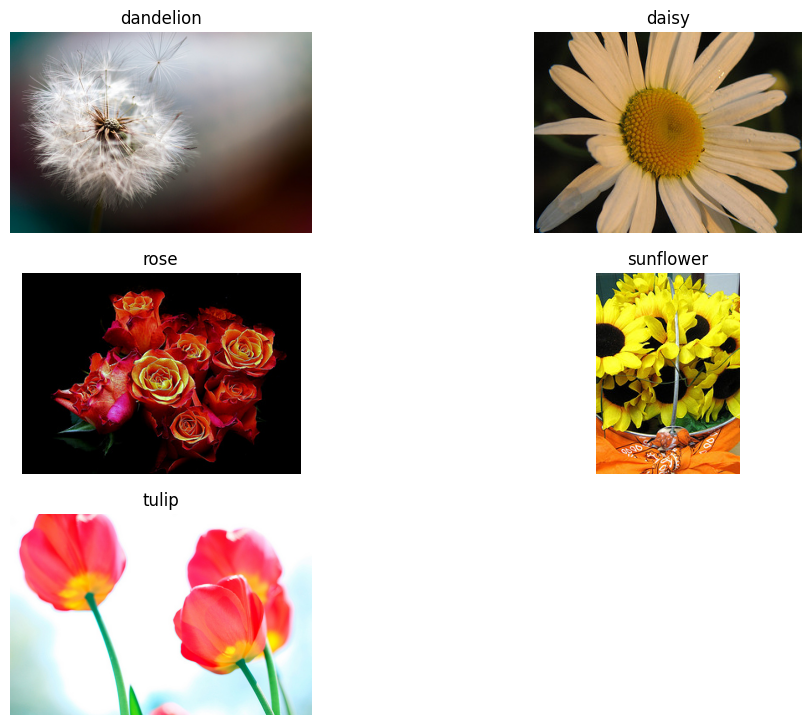

In [58]:
train_path="data_split/train"
class_dirs = os.listdir(train_path)
plt.figure(figsize=(12, 12))
for i in range(len(class_dirs)):
    plt.subplot(4,2,i+1)
    img_path = f"{train_path}/{class_dirs[i]}/{os.listdir(f'{train_path}/{class_dirs[i]}')[0]}"
    img = plt.imread(img_path)
    plt.title(class_dirs[i])
    plt.axis("off")
    plt.imshow(img,cmap="brg")

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'data_split/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,  seed=42
)
validation_generator = val_test_datagen.flow_from_directory(
    'data_split/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False, seed=42
)
test_generator = val_test_datagen.flow_from_directory(
    'data_split/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False, seed=42
)

Found 3019 images belonging to 5 classes.
Found 649 images belonging to 5 classes.
Found 649 images belonging to 5 classes.


In [ ]:
import pandas as pd

train_counts = {expression: len(os.listdir(os.path.join("/content/data_split/train", expression)))
                for expression in os.listdir("/content/data_split/train")}
train_count_df = pd.DataFrame(train_counts, index=['train'])

In [ ]:
train_count_df

,dandelion,daisy,rose,sunflower,tulip
train,736,534,548,513,688


<Axes: >

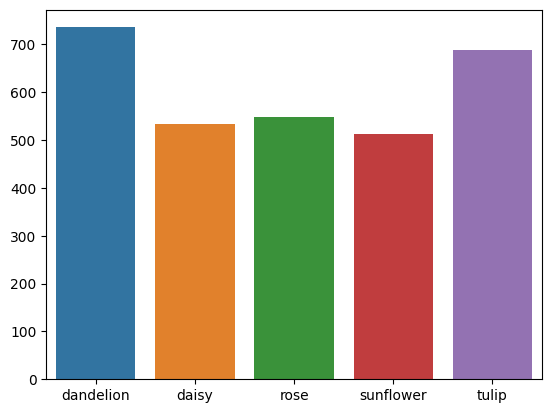

In [ ]:
import seaborn as sns
sns.barplot(data=train_count_df)

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, BatchNormalization, Dense
from tensorflow.keras.optimizers import Adam

input_tensor = Input(shape=(224, 224, 3))

base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=input_tensor, pooling='max')
x = base_model.output
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
x = Dense(128, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.5)(x)

predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history = model.fit(train_generator, validation_data=validation_generator, epochs=20)

Epoch 1/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 135s 847ms/step - accuracy: 0.2782 - loss: 2.3021 - val_accuracy: 0.2435 - val_loss: 2.4330
Epoch 2/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 49s 511ms/step - accuracy: 0.5872 - loss: 1.1597 - val_accuracy: 0.2435 - val_loss: 2.0180
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 48s 508ms/step - accuracy: 0.7038 - loss: 0.8903 - val_accuracy: 0.2435 - val_loss: 2.3311
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 49s 511ms/step - accuracy: 0.7958 - loss: 0.5951 - val_accuracy: 0.2435 - val_loss: 2.4663
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 48s 508ms/step - accuracy: 0.8246 - loss: 0.5325 - val_accuracy: 0.2650 - val_loss: 2.3319
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 48s 508ms/step - accuracy: 0.8300 - loss: 0.4873 - val_accuracy: 0.4361 - val_loss: 1.5341
Epoch 7/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 49s 510ms/step - accuracy: 0.8628 - loss: 0.4485 - val_accuracy: 0.6086 - val_loss: 1.0361
Epoch 8/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 49s 510ms/step - accuracy: 0.8814 - loss: 0.3870 - val_acc

In [ ]:
test_data=model.evaluate(test_generator)

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.9113 - loss: 0.3068


In [ ]:
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis = 1)
y_true = test_generator.classes

21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 298ms/step


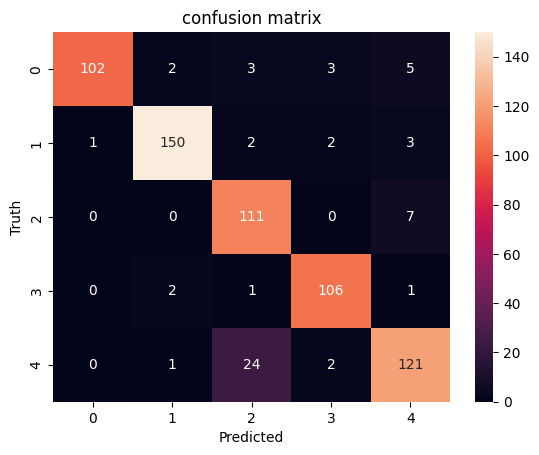

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title("confusion matrix")
plt.show()


In [ ]:
import random

class_indices = test_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

print("Sample Predictions:")


num_samples = 5
random_indices = random.sample(range(len(y_true)), num_samples)

for i, sample_idx in enumerate(random_indices):
    true_label_idx = y_true[sample_idx]
    predicted_label_idx = y_pred[sample_idx]
    confidence_scores = predictions[sample_idx]

    true_label_name = idx_to_class[true_label_idx]
    predicted_label_name = idx_to_class[predicted_label_idx]
    predicted_confidence = confidence_scores[predicted_label_idx]

    print(f"Sample {i+1}:")
    print(f"  True Label: {true_label_name}")
    print(f"  Predicted Label: {predicted_label_name}")
    print(f"  Confidence: {predicted_confidence:.4f}")


Sample Predictions:
Sample 1:
  True Label: tulip
  Predicted Label: tulip
  Confidence: 0.9867
Sample 2:
  True Label: tulip
  Predicted Label: tulip
  Confidence: 0.5748
Sample 3:
  True Label: rose
  Predicted Label: rose
  Confidence: 0.9999
Sample 4:
  True Label: daisy
  Predicted Label: daisy
  Confidence: 1.0000
Sample 5:
  True Label: daisy
  Predicted Label: daisy
  Confidence: 0.9979
